In [55]:
import pandas as pd
import quandl, math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [10]:
# using quandl wiki data for this problem 
df = quandl.get('WIKI/GOOGL')

In [11]:
# trying to see how data looks
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [12]:
# Picking up the colums we need
df  = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume',]]

In [13]:
# feature engineering
df['HL_PCT'] = (df['Adj. High']-df['Adj. Close'])/df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close']-df['Adj. Open'])/df['Adj. Open'] * 100.0

# Again picking up the dates we need
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]

In [14]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [38]:
# Building target variable

forecast_col = 'Adj. Close'
df.fillna(-9999, inplace = True) # filling missing data

forecast_out = int(math.ceil(0.01*len(df)))

In [39]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [40]:
print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  3.712563    0.324968   44659000.0  67.739104
2004-08-20   54.322689  0.710922    7.227007   22834300.0  69.399229
2004-08-23   54.869377  3.729433   -1.227880   18256100.0  68.752232
2004-08-24   52.597363  6.417469   -5.726357   15247300.0  69.639972
2004-08-25   53.164113  1.886792    1.183658    9188600.0  69.078238


In [49]:
x = np.array(df.drop(['label'],1))
x = x[:-forecast_out]
x_lately = x[-forecast_out:]

x = preprocessing.scale(x)
df.dropna(inplace=True)
y = np.array(df['label'])

print(len(x),len(y))

3019 3019


In [50]:
x_train,x_test,y_train,y_test = cross_validation.train_test_split(x,y,test_size = 0.2)

In [51]:
print(len(x_train),len(y_train))
print(len(x_test),len(y_test))

2415 2415
604 604


In [52]:
classifier = LinearRegression()
classifier.fit(x_train,y_train) # fit is synonymous with train

rsquared = classifier.score(x_test,y_test) # score is synonymous with test
print(rsquared)

0.9673603831024318


In [53]:
# Doing regression with SVM
classifier2 = svm.SVR()
classifier2.fit(x_train,y_train) # fit is synonymous with train

rsquared_svr = classifier2.score(x_test,y_test) # score is synonymous with test
print(rsquared_svr)

0.8119358801494848


In [57]:
# Forecasting the model over data kept aside, x_lately

forecast_set = classifier.predict(x_lately)
print(forecast_set,rsquared,forecast_out)

[ -4513101.18590226  -4133270.65924258  -4201728.66377488
  -3044603.6916646   -4356497.01366944  -4186458.77046373
  -3848752.59605318  -2930207.83511387  -3074420.17729366
  -4712030.92111242  -5660814.20279058  -4423445.06223262
  -3234663.32439637  -2719773.06370877  -2997371.17637149
  -3079411.90414093  -3427618.85669555  -4681883.96736885
 -10865166.90816367 -15105730.51657957  -8931318.98587037
  -5836515.72984518  -4233314.84288048  -3080480.68215522
  -5268961.92622042  -3515092.65452096  -4671065.80376238
  -2606683.65892078  -3696267.33970199  -2543348.86043967
  -2641759.31587872] 0.9673603831024318 31


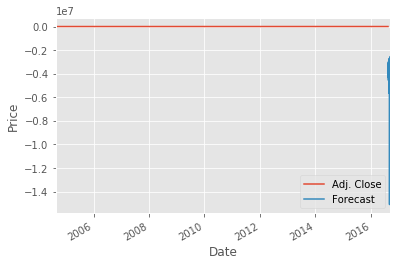

In [56]:
df['Forecast'] = np.nan

last_data = df.iloc[-1].name
last_unix = last_data.timestamp()
one_day = 86400 # no of seconds in a day
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()